<a href="https://colab.research.google.com/github/wisrovi/RedesNeuronales/blob/master/07MAIR-WilliamSteveRodriguezVillamizar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0.0-alpha0

In [0]:
urlArchivos = "https://drive.google.com/drive/folders/1w2w5dAF269C646RBwwU33YLNUG4JRfh9?usp=sharing"

In [27]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
###################################################################################################
BASE_FOLDER = '/content/drive/My Drive/Master IA/Redes Neuronales/'
BASE_FOLDER = '/content/gdrive/My Drive/Master IA/Redes Neuronales/'
###################################################################################################

In [29]:
!ls "/content/gdrive/My Drive/Master IA/Redes Neuronales/"

'07MAIR_Actividad 1.ipynb'   pickle_all_classes.pickle
 caltech101_dataset	     pickle_all_images_df-002.pickle
 caltech101_dataset.zip      preprocesado_caltech101.ipynb


In [0]:
import pickle
import matplotlib.pyplot as plt
import numpy as np


from keras import models
from keras import layers


from sklearn.model_selection import train_test_split

#para autoescalar la imagen al tamaño requerido por la red a reentrenar
from keras.applications.inception_v3 import preprocess_input

In [31]:
with open(BASE_FOLDER+"pickle_all_images_df-002.pickle", "rb") as input_file:
    x_train_all = pickle.load(input_file)
with open(BASE_FOLDER+"pickle_all_classes.pickle", "rb") as input_file:
    y_train_all = pickle.load(input_file)

number_of_classes = len(y_train_all)

print("Entradas: ",x_train_all.shape)
print("Salidas: ", number_of_classes)

Entradas:  (9145, 128, 128, 3)
Salidas:  9145


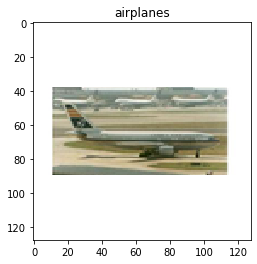

In [32]:
# show image
imagenVer = 250

imgplot = plt.imshow(x_train_all[imagenVer])
plt.title(y_train_all[imagenVer])
plt.show()

In [0]:
# Transformando las labels de texto a valores numéricos
y = np.unique(y_train_all)
mapping = { key : value for key,value in zip(y,range(len(y)))}
processed_y = np.array([mapping[i] for i in y_train_all])

In [34]:
print(processed_y[imagenVer], y_train_all[imagenVer])

6 airplanes


In [52]:
# dividir los datos entre training, test y predic
X_train, X_test, y_train, y_test = train_test_split(
    x_train_all, processed_y, 
    test_size=0.33, 
    random_state=42)

X_test, X_predic, y_test, y_predic = train_test_split(
    X_test, y_test, 
    test_size=0.33, 
    random_state=51)


print("Training (66.98%)") 
print("X_train", X_train.shape)
print("y_train", len(y_train))
print() 
print("Test (22.1%)") 
print("X_test", X_test.shape)
print("y_test", len(y_test))
print()
print("Predict (10.89%)") 
print("X_predic", X_predic.shape)
print("y_predic", len(y_predic))

Training (66.98%)
X_train (6127, 128, 128, 3)
y_train 6127

Test (22.1%)
X_test (2022, 128, 128, 3)
y_test 2022

Predict (10.89%)
X_predic (996, 128, 128, 3)
y_predic 996


In [36]:
# VGG16, VGG19, ResNet50, 
#Xception, InceptionV3, InceptionResNetV2, 
#MobileNetV2, DenseNet, RasNet



Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [0]:
#https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

from keras.applications import VGG16 
conv_base = VGG16(weights='imagenet',
                 include_top=False, # Si se deben incluir o no las capas de salida para el modelo
                 input_shape=(128,128,3))

congelarTodoModeloImagenet = False
if congelarTodoModeloImagenet:
  conv_base.trainable = False
else:
  # Freeze the layers except the last 4 layers
  cantidadCapasFinalesDescongelar = 4
  for layer in conv_base.layers[:-cantidadCapasFinalesDescongelar]:
      layer.trainable = False
      pass

  # Check the trainable status of the individual layers
  for layer in conv_base.layers:
      pass
      print(layer, layer.trainable)



#conv_base.summary()

In [0]:
from keras.applications.inception_v3 import InceptionV3

conv_base = InceptionV3(
      weights='imagenet', 
      include_top=True)




In [45]:
pre_trained_model = models.Sequential()
pre_trained_model.add(conv_base)

# conectarlo a nueva parte densa
pre_trained_model.add(layers.Dense(number_of_classes, activation='relu'))
pre_trained_model.add(layers.Dense(1, activation='relu'))

pre_trained_model.summary()

# compilar el modelo
pre_trained_model.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

#entrenar el modelo
history = pre_trained_model.fit(X_train, y_train, epochs=25)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1000)              23851784  
_________________________________________________________________
dense_12 (Dense)             (None, 9145)              9154145   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9146      
Total params: 33,015,075
Trainable params: 11,212,291
Non-trainable params: 21,802,784
_________________________________________________________________



ValueError: ignored

In [0]:
loss,accuracy = pre_trained_model.evaluate(X_test_eval,y_test_eval)

print('loss {} accuracy {}'.format(loss,accuracy))

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


KeyError: ignored

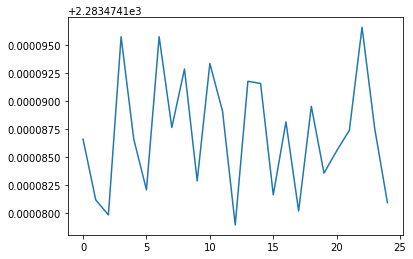

In [59]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plot_history(history)

In [0]:
def plot_pred(pred):
    plt.figure(figsize=(8, 2))
    classes = [c[1] for c in pred]
    probas = [c[2] for c in pred]
    y_pos = np.arange(len(classes))
    plt.barh(y_pos, probas, align='center')
    plt.yticks(y_pos, classes)
    plt.gca().invert_yaxis()
    plt.xlabel('Probability')
    plt.xlim(0, 1)

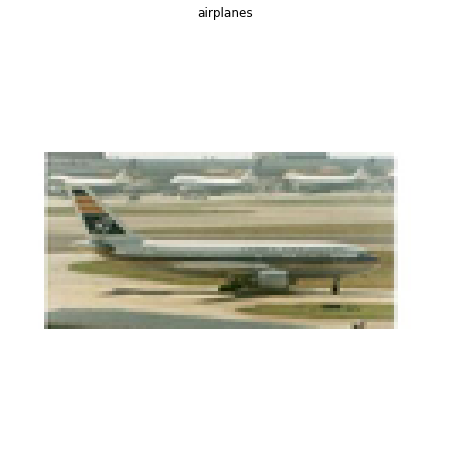

In [78]:
def plot_image(img, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_image(x_train_all[250], y_train_all[250])

In [0]:

print("conjunto datos predecir: ", len(X_test_predic))
cantidadPorcentajesMostrar = 5 #muestra los de mayor porcentaje

In [0]:
from skimage.transform import resize
from keras.applications.inception_v3 import decode_predictions
def predecir(model, dato):
  dato = resize(dato, (299, 299), anti_aliasing=True)

  dato = preprocess_input(dato)
  dato = np.expand_dims(dato, axis=0) #añadir una dimension mas para que el modelo lo pueda evaluar

  prediccion = model.predict(dato) #predecir
  return decode_predictions(prediccion, top=cantidadPorcentajesMostrar)[0]

conjunto datos predecir:  996


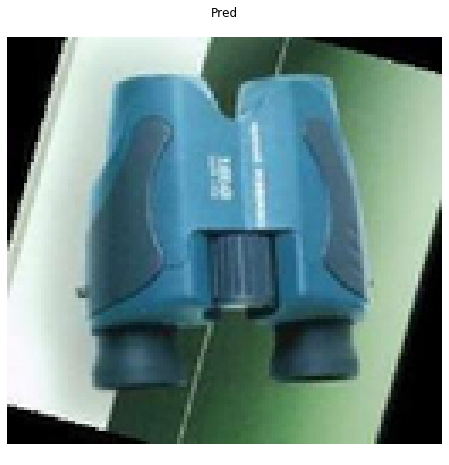

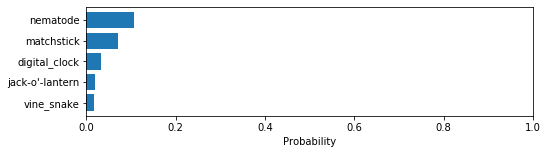

In [79]:
dato_evaluar = X_predic[100]
pred = predecir(conv_base, dato_evaluar)
plot_image(dato_evaluar, "Pred")
plot_pred(pred)

In [56]:
print(X_test_predic[0].shape)
print(type(X_test_predic[0]))

(128, 128, 3)
<class 'numpy.ndarray'>


In [80]:
nombreModeloGuardado = "model.json"
nombrePesosGuardados = "model.h5"

def GuardarModelo(model, archivoModelo, archivoPesos):
    try:
        # serializar el modelo a JSON
        model_json = model.to_json()
        with open(archivoModelo, "w") as json_file:
            json_file.write(model_json)
            print("Modelo guardado!")
        # serializar los pesos a HDF5
        model.save_weights(archivoPesos)
        print("Pesos Guardados!")
        return True
    except:
        return False

GuardarModelo(conv_base, BASE_FOLDER + "model.json",  BASE_FOLDER + "model.h5")

Modelo guardado!
Pesos Guardados!


In [82]:
from keras.models import model_from_json

def CargarModeloGuardado(archivoModelo, archivoPesos):
    # cargar json y crear el modelo
    json_file = open(archivoModelo, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    print("Modelo Cargado!")

    # cargar pesos al nuevo modelo
    loaded_model.load_weights(archivoPesos)
    print("Pesos Cargados!")
    
    # Compilar modelo cargado y listo para usar.
    loaded_model.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
    print("Modelo compilado!")
    return loaded_model

modeloCargado = CargarModeloGuardado(BASE_FOLDER + "model.json",  BASE_FOLDER + "model.h5")
#modeloCargado.summary()

Modelo Cargado!
Pesos Cargados!
Modelo compilado!
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 149, 149, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 149, 149, 32) 0           batch_normalization_189[0][0]    
_____________________________________

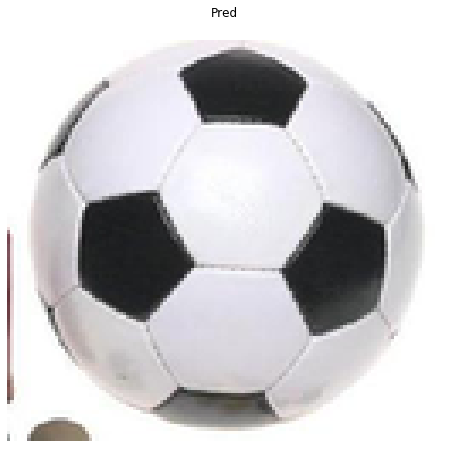

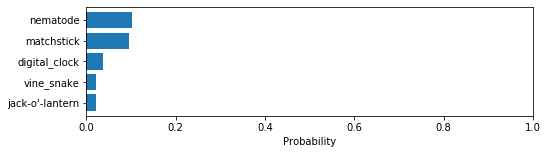

In [83]:
dato_evaluar = X_predic[150]
pred = predecir(modeloCargado, dato_evaluar)
plot_image(dato_evaluar, "Pred")
plot_pred(pred)

In [87]:
dato_evaluar = X_predic[350]
pred = predecir(modeloCargado, dato_evaluar)

from sklearn.metrics import classification_report 
scnn_report = classification_report(np.argmax(y_predic, axis=1), pred)  
print(scnn_report) 

AxisError: ignored

In [0]:
url = 'https://www.aprendemachinelearning.com/clasificacion-de-imagenes-en-python/'